# Plot discharge figure
Plot comparison between observed and Flux-PIHM and Cycles-L predicted discharge at the WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pihm import read_output
from my_funcs import nse
from setting import WE38_DISCHARGE_OBS

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

## Read observations

In [3]:
df = pd.read_csv(
    WE38_DISCHARGE_OBS,
    delimiter=',',
    skipinitialspace=True,
    usecols=[1, 2],
    header=0,
    names=['date', 'q'],
    parse_dates=['date'],
)
df = df.sort_values('date')
df.set_index('date', inplace=True)

# Calculate 7-day mean
obs = df.rolling('7d', min_periods=3, center=True, win_type=None).mean()
obs.dropna(inplace=True)
obs.drop(obs[obs.index < datetime(2000, 1, 1)].index, inplace=True)
obs['doy'] = obs.index.dayofyear

## Plot

WE38 NSE 0.5489601074546652
WE38 DOY NSE 0.6839846298580787
WE38_hydro NSE 0.5980844114538304
WE38_hydro DOY NSE 0.5562635362624415


Text(0.675, 0.52, '(d)')

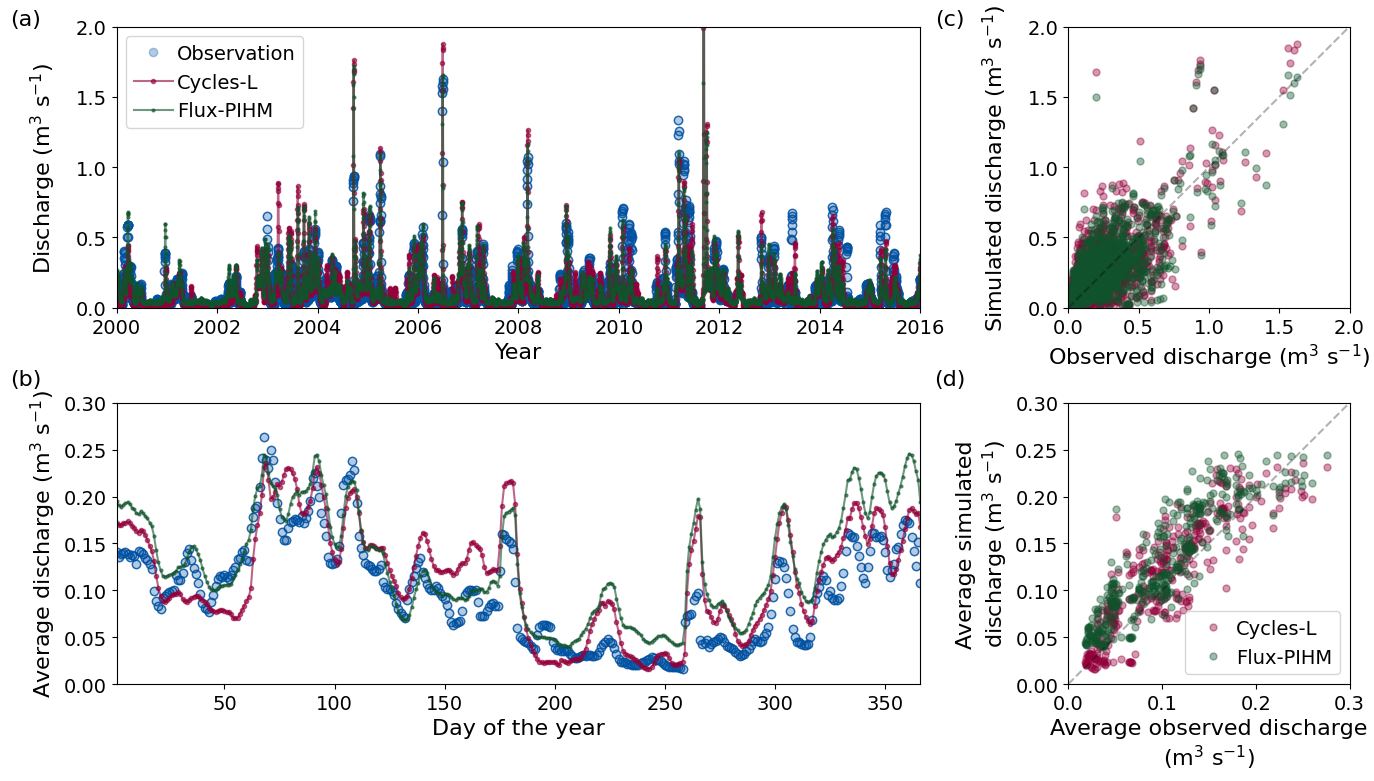

In [4]:
scenarios = {
    "WE38": ["Cycles-L", "#93003a", 6],
    "WE38_hydro": ["Flux-PIHM", "#10542c", 4],
}

fig = plt.figure(figsize=(14, 8))

lines = []
dots = []
axs = []
axs.append(fig.add_subplot(2, 3, (1, 2)))
axs.append(fig.add_subplot(2, 3, (4, 5)))
axs.append(fig.add_subplot(2, 3, 3))
axs.append(fig.add_subplot(2, 3, 6))

# Plot daily discharge observation
axs[0].plot(
    obs.index, obs['q'],
    'o',
    color="#0051a2",
    mfc='none',
    alpha=0.8,
)
_line, = axs[0].plot(
    obs.index, obs['q'],
    'o',
    color="#0051a2",
    alpha=0.3,
    label='Observation',
)
lines.append(_line)

# Plot discharge observation averaged to each day of year
obs_doy = obs.groupby(obs['doy']).mean()

axs[1].plot(
    obs_doy.index,
    obs_doy['q'],
    'o',
    color="#0051a2",
    alpha=0.8,
    mfc='none',
)
axs[1].plot(
    obs_doy.index,
    obs_doy['q'],
    'o',
    color="#0051a2",
    alpha=0.3,
)

for s in scenarios:
    # Read simulations
    sim_time, _q, _, unit = read_output('../', 'WE38', s, 'river.flx1')
    # Adjust time offset
    sim_time -= timedelta(days=1)
    simulation = pd.DataFrame({'q': _q[:, 0], 'date': sim_time})
    simulation.set_index('date', inplace=True)
    # Calculate 7-day mean
    simulation = simulation.rolling('7d', min_periods=3, center=True, win_type=None).mean()
    simulation.dropna(inplace=True)

    # Plot one-to-one comparison between observation and simulation
    merged = obs.join(simulation, how='inner', lsuffix='_obs', rsuffix='_sim')
    _dot, = axs[2].plot(merged["q_obs"], merged["q_sim"],
        "o",
        color=scenarios[s][1],
        ms=5,
        alpha=0.4,
        label=scenarios[s][0]
    )
    dots.append(_dot)
    print(s, 'NSE', nse(merged['q_obs'], merged['q_sim']))

    merged = merged.groupby(merged['doy']).mean()
    axs[3].plot(merged["q_obs"], merged["q_sim"],
        "o",
        color=scenarios[s][1],
        alpha=0.4,
        ms=5,
        label=scenarios[s][0]
    )
    print(s, 'DOY NSE', nse(merged['q_obs'], merged['q_sim']))

    # Plot daily discharge simulation    
    _line, = axs[0].plot(simulation.index, simulation['q'],
        ".-",
        color=scenarios[s][1],
        alpha=0.6,
        ms=scenarios[s][2],
        label=scenarios[s][0]
    )
    lines.append(_line)

    # Plot discharge simulation averaged to each day of year
    axs[1].plot(merged.index, merged['q_sim'],
        '.-',
        color=scenarios[s][1],
        alpha=0.6,
        ms=scenarios[s][2],
        label=scenarios[s][0]
    )

# Set x and y axis labels
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Discharge (' + unit + ')')

## Clean up the x axis dates
axs[0].set_ylim(0, 2)
axs[0].set_xlim(datetime(2000, 1, 1), datetime(2016, 1, 1))
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

axs[1].set_xlim(1, 366)
axs[1].set_ylim(0, 0.3)
# Set x and y axis labels
axs[1].set_xlabel('Day of the year')
axs[1].set_ylabel('Average discharge (m$^3$ s$^{-1}$)')

axs[0].legend(
    handles=lines,
    loc='upper left',
    handletextpad=0.2,
)
axs[3].legend(
    handles=dots,
    loc='lower right',
    handletextpad=0.2,
)

axs[2].plot([0, 5], [0, 5], 'k--', alpha=0.3)
# Set x and y axis labels
axs[2].set_xlabel('Observed discharge (' + unit + ')')
axs[2].set_ylabel('Simulated discharge (' + unit + ')')

## Clean up the x axis dates
axs[2].set_ylim(0, 2)
axs[2].set_xlim(0, 2)
axs[2].set_aspect("equal")

axs[3].plot([0, 5], [0, 5], 'k--', alpha=0.3)
axs[3].set_xlabel('Average observed discharge\n(' + unit + ')')
axs[3].set_ylabel('Average simulated\ndischarge (' + unit + ')')
axs[3].set_ylim(0, 0.3)
axs[3].set_xlim(0, 0.3)
axs[3].set_aspect("equal")

plt.tight_layout()
fig.align_ylabels(axs)

fig.text(0.015, 0.97,'(a)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.97,'(c)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.015, 0.52,'(b)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.52,'(d)', ha='center', va='center', transform=fig.transFigure)
#fig.savefig("../figures/discharge.png", dpi=300)
#fig.savefig("../figures/discharge.pdf", dpi=300)